<a href="https://colab.research.google.com/github/1realMicheal/AI-Micheal-Boadi/blob/main/trashsorting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [2]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [3]:
!pwd

!ls /content/drive/MyDrive/realwastedataset/realwaste/realwaste-main/RealWaste



/content
 Cardboard	  Glass  'Miscellaneous Trash'	 Plastic	  Vegetation
'Food Organics'   Metal   Paper			'Textile Trash'


In [4]:
datasetpath = "/content/drive/MyDrive/realwastedataset/realwaste/realwaste-main/RealWaste"

In [15]:
img_height = 224
img_width = 224
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    datasetpath,
    image_size=(224, 224),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    labels='inferred',
    validation_split=0.3,
    subset="training"
)

valtest_ds = tf.keras.preprocessing.image_dataset_from_directory(
    datasetpath,
    image_size=(224, 224),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    labels='inferred',
    validation_split=0.3,
    subset="validation")

valtest_size = valtest_ds.cardinality().numpy()

val_size  = int(valtest_size * 0.67)   # 2/3 validation
test_size = valtest_size - val_size

val_ds  = valtest_ds.take(val_size)
test_ds = valtest_ds.skip(val_size)



Found 4752 files belonging to 9 classes.
Using 3327 files for training.
Found 4752 files belonging to 9 classes.
Using 1425 files for validation.


In [21]:
print(len(train_ds))

208


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


In [22]:
from tensorflow.keras import layers, models
num_classes = 9

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,121 (42.61 MB)

 Trainable params: 11,170,121 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_cb = ModelCheckpoint(
    filepath="/content/best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)


earlystop_cb = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2076 - loss: 2.2987
Epoch 1: val_accuracy improved from -inf to 0.40312, saving model to /content/best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1062s 5s/step - accuracy: 0.2080 - loss: 2.2971 - val_accuracy: 0.4031 - val_loss: 1.6852 - learning_rate: 0.0010
Epoch 2/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4478 - loss: 1.5070
Epoch 2: val_accuracy improved from 0.40312 to 0.45104, saving model to /content/best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 40s 190ms/step - accuracy: 0.4480 - loss: 1.5066 - val_accuracy: 0.4510 - val_loss: 1.5574 - learning_rate: 0.0010
Epoch 3/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5468 - loss: 1.2227
Epoch 3: val_accuracy improved from 0.45104 to 0.51458, saving model to /content/best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 30s 144ms/step - accuracy: 0.5470 - loss: 1.2223 - val_accuracy: 0.5146 - val_loss: 1.4861 - learning_rate: 0.0010
Epoch 4/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6768 - loss: 0.9286
Epoch 4: val_accuracy improved from 0.51458 to 0.57292, saving model to /content/best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - accuracy: 0.6769 - loss: 0.9283 - val_accuracy: 0.5729 - val_loss: 1.4062 - learning_rate: 0.0010
Epoch 5/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7897 - loss: 0.6306
Epoch 5: val_accuracy did not improve from 0.57292
208/208 ━━━━━━━━━━━━━━━━━━━━ 25s 118ms/step - accuracy: 0.7898 - loss: 0.6304 - val_accuracy: 0.5552 - val_loss: 1.5296 - learning_rate: 0.0010
Epoch 6/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8471 - loss: 0.4675
Epoch 6: val_accuracy did not improve from 0.57292
208/208 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - accuracy: 0.8472 - loss: 0.4674 - val_accuracy: 0.5010 - val_loss: 2.2130 - learning_rate: 0.0010
Epoch 7/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8976 - loss: 0.3225
Epoch 7: val_accuracy did not improve from 0.57292

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
208/208 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - accuracy: 0.8977 - loss: 0.3222

208/208 ━━━━━━━━━━━━━━━━━━━━ 25s 118ms/step - accuracy: 0.9453 - loss: 0.1788 - val_accuracy: 0.5917 - val_loss: 2.2603 - learning_rate: 3.0000e-04
Epoch 9/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9805 - loss: 0.0720
Epoch 9: val_accuracy improved from 0.59167 to 0.60312, saving model to /content/best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 25s 118ms/step - accuracy: 0.9805 - loss: 0.0719 - val_accuracy: 0.6031 - val_loss: 2.4035 - learning_rate: 3.0000e-04
Epoch 10/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9902 - loss: 0.0371
Epoch 10: val_accuracy improved from 0.60312 to 0.60417, saving model to /content/best_model.h5



Epoch 10: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
208/208 ━━━━━━━━━━━━━━━━━━━━ 25s 118ms/step - accuracy: 0.9902 - loss: 0.0371 - val_accuracy: 0.6042 - val_loss: 2.5965 - learning_rate: 3.0000e-04
Epoch 11/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9966 - loss: 0.0186
Epoch 11: val_accuracy did not improve from 0.60417
208/208 ━━━━━━━━━━━━━━━━━━━━ 25s 121ms/step - accuracy: 0.9966 - loss: 0.0186 - val_accuracy: 0.6010 - val_loss: 2.5177 - learning_rate: 9.0000e-05
Epoch 12/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9996 - loss: 0.0106
Epoch 12: val_accuracy did not improve from 0.60417
208/208 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - accuracy: 0.9996 - loss: 0.0106 - val_accuracy: 0.5990 - val_loss: 2.5630 - learning_rate: 9.0000e-05
Epoch 13/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9995 - loss: 0.0084
Epoch 13: val_accuracy did not improve from 0.60417

Epoch 13: ReduceLROnPlateau reducing learning rate to 2.7

208/208 ━━━━━━━━━━━━━━━━━━━━ 25s 121ms/step - accuracy: 0.9995 - loss: 0.0062 - val_accuracy: 0.6052 - val_loss: 2.7187 - learning_rate: 2.7000e-05
Epoch 16/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 0.0058
Epoch 16: val_accuracy did not improve from 0.60521

Epoch 16: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
208/208 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.6010 - val_loss: 2.7907 - learning_rate: 2.7000e-05
Epoch 17/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss: 0.0055
Epoch 17: val_accuracy did not improve from 0.60521
208/208 ━━━━━━━━━━━━━━━━━━━━ 24s 116ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.5979 - val_loss: 2.7511 - learning_rate: 8.1000e-06
Epoch 18/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss: 0.0052
Epoch 18: val_accuracy did not improve from 0.60521
208/208 ━━━━━━━━━━━━━━━━━━━━ 29s 139ms/step - accuracy: 1.

30/30 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.6251 - loss: 2.7576
Test Accuracy: 0.6215053796768188
Test Loss: 2.7642996311187744


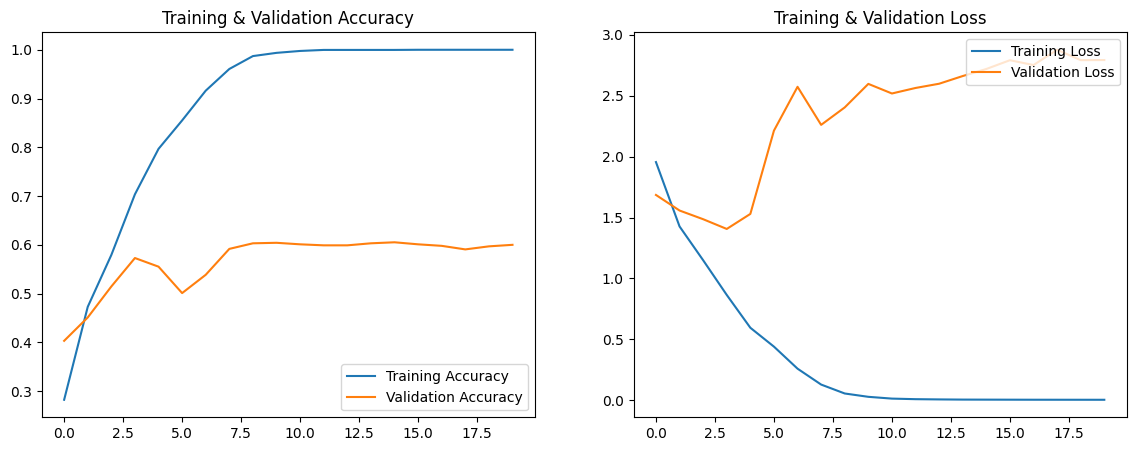

In [24]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')

plt.show()
